In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

### Data downloading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/Alzheimer's MRI/Train" Alzheimer_Train
!cp -r "/content/drive/MyDrive/Alzheimer's MRI/Test" Alzheimer_Test

In [ ]:
train_dir = "/content/Alzheimer_Train"
test_dir = "/content/Alzheimer_Test"

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (180, 180)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 34594 files belonging to 3 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6468 files belonging to 3 classes.


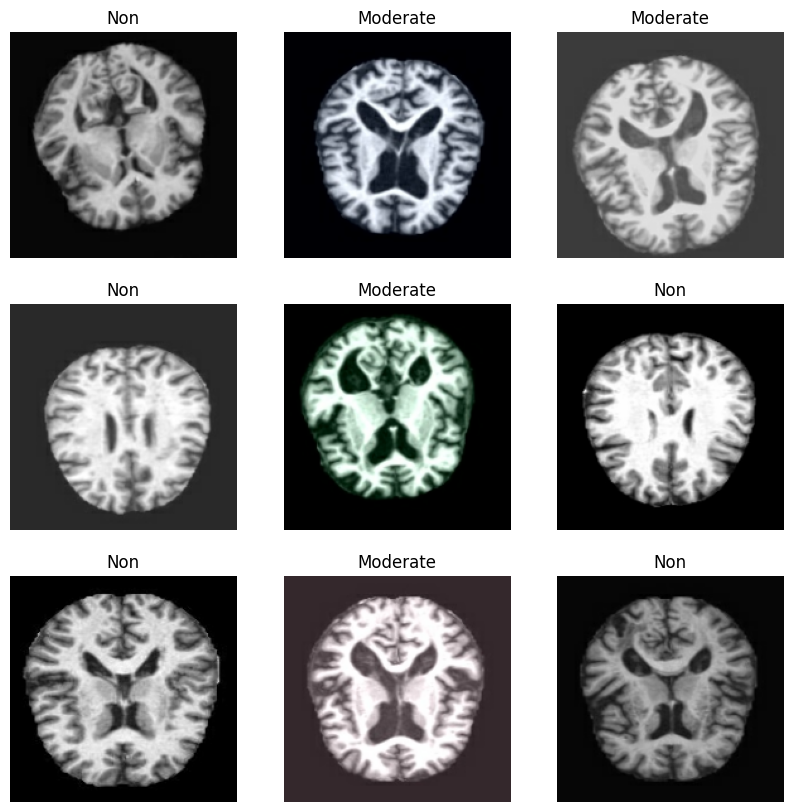

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 866
Number of test batches: 203


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  #tf.keras.layers.RandomRotation(0.2),
])

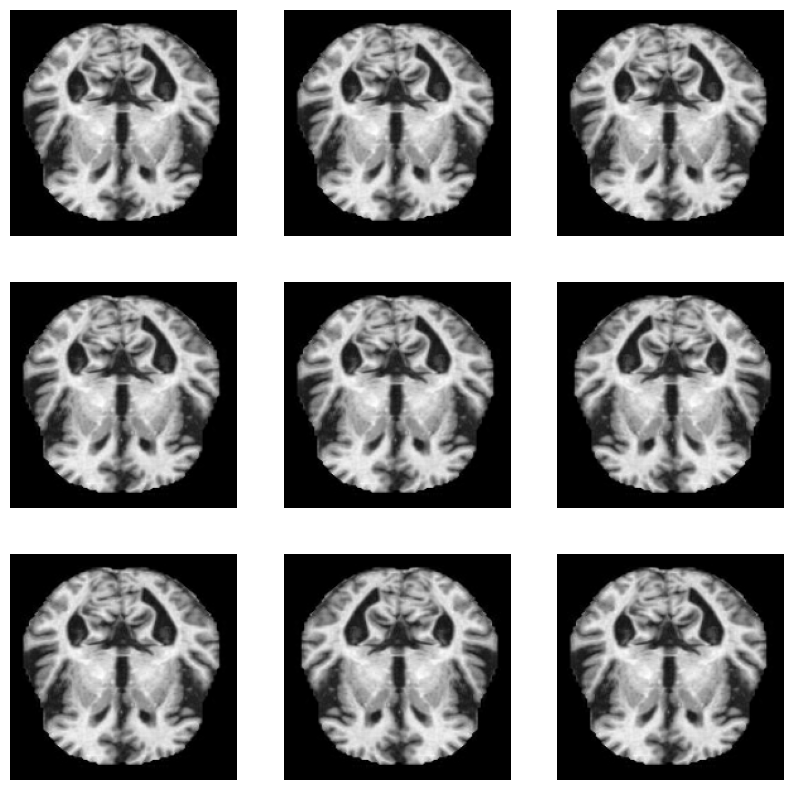

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale Pixel Value



In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create Base model from Pretrained CNN

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


### Frozen convolution

In [ ]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

### Category header

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Model Compile


In [ ]:
base_learning_rate = 0.0001 #change for 0.0005 0.00005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),#change for SGD
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

56

### Model Training




In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

216/216 [==============================] - 10s 31ms/step - loss: 1.6941 - accuracy: 0.2810


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.69
initial accuracy: 0.28


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
866/866 [==============================] - 71s 57ms/step - loss: 0.7279 - accuracy: 0.6667 - val_loss: 1.1394 - val_accuracy: 0.5456
Epoch 2/10
866/866 [==============================] - 54s 56ms/step - loss: 0.4686 - accuracy: 0.7907 - val_loss: 0.4866 - val_accuracy: 0.7859
Epoch 3/10
866/866 [==============================] - 55s 58ms/step - loss: 0.2889 - accuracy: 0.8797 - val_loss: 0.3037 - val_accuracy: 0.8896
Epoch 4/10
866/866 [==============================] - 56s 60ms/step - loss: 0.2036 - accuracy: 0.9174 - val_loss: 0.2898 - val_accuracy: 0.8830
Epoch 5/10
866/866 [==============================] - 56s 61ms/step - loss: 0.1331 - accuracy: 0.9486 - val_loss: 0.3518 - val_accuracy: 0.8634
Epoch 6/10
866/866 [==============================] - 56s 60ms/step - loss: 0.0901 - accuracy: 0.9662 - val_loss: 0.1089 - val_accuracy: 0.9611
Epoch 7/10
866/866 [==============================] - 55s 60ms/step - loss: 0.0677 - accuracy: 0.9755 - val_loss: 0.1785 - val_accuracy:

In [ ]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

### K-fold

In [ ]:
import numpy as np
sample_weight = np.load("/content/drive/MyDrive/adversarial_weights")

In [ ]:
train_images = np.concatenate(list(train_dataset.map(lambda x, y:x)))
train_labels = np.concatenate(list(train_dataset.map(lambda x, y:y)))

val_images = np.concatenate(list(validation_dataset.map(lambda x, y:x)))
val_labels = np.concatenate(list(validation_dataset.map(lambda x, y:y)))

test_images = np.concatenate(list(test_dataset.map(lambda x, y:x)))
test_labels = np.concatenate(list(test_dataset.map(lambda x, y:y)))

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)


In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

for train, val in kfold.split(inputs, targets):
  
  model_inputs = tf.keras.Input(shape=(180, 180, 3))
  model = tf.keras.Model(model_inputs, outputs)

  base_learning_rate = 0.0005 #change for 0.0001 0.00005
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),#change for Adam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
  
  history = model.fit(inputs[train], targets[train],
                      batch_size=BATCH_SIZE,
                      sample_weight = sample_weight,
                      epochs=5)
  scores = model.evaluate(inputs[val], targets[val], verbose=0)


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_images, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_images, y_pred_bool))

In [ ]:
from tensorflow.keras.models import Model
feature_layer = model.get_layer('global_average_pooling2d')

mobilent_feature_model = Model(inputs=model.input, outputs=feature_layer.output)

In [ ]:
features = mobilent_feature_model.predict(test_dataset)
train_features = mobilent_feature_model.predict(train_dataset)

866/866 [==============================] - 44s 46ms/step


In [ ]:
# Initialize empty lists to store x_test and y_test
x_test = []
y_test = []

# Iterate through the test_dataset
for images, labels in test_dataset:
    x_test.append(images)
    y_test.append(labels)

# Concatenate the batches to create the final x_test and y_test arrays
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Convert labels to numpy array if needed
y_test = y_test.numpy()

# Print shapes for verification
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (6468, 180, 180, 3)
y_test shape: (6468,)


In [ ]:
predictions
y_pred_bool = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bool,digits=4))

              precision    recall  f1-score   support

           0     0.9951    0.8891    0.9392      2300
           1     0.9865    0.9824    0.9845       968
           2     0.9243    0.9962    0.9589      3200

    accuracy                         0.9561      6468
   macro avg     0.9687    0.9559    0.9609      6468
weighted avg     0.9588    0.9561    0.9557      6468



### UMAP semantic feature dimensionality reduction

In [ ]:
from tensorflow.keras.models import Model
feature_layer = model.get_layer('global_average_pooling2d')

mobilent_feature_model = Model(inputs=model.input, outputs=feature_layer.output)
features = mobilent_feature_model.predict(test_dataset)

In [ ]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

### Visualization



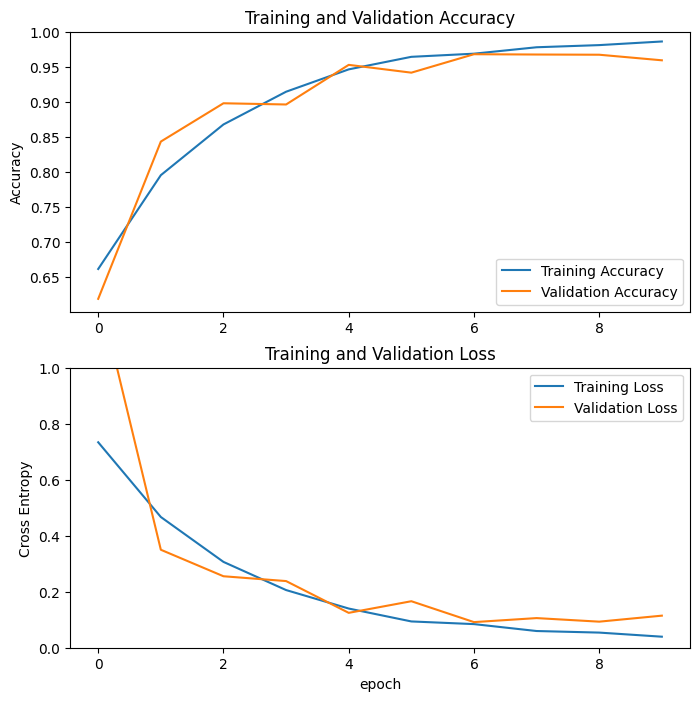

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()